# Energy consumption prediction using LSTM/GRU in PyTorch

In this notebook, we'll be using GRU and LSTM models for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

Link to the GitHub repository: https://github.com/amirmasoudsfd/energy-consumption-prediction.

The goal of this implementation is to **create a model that can accurately predict the energy usage in the next hour** given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we'll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will use the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

## Important Points:
* Basic knowledge of Deep Learning, Python, Numpy, Pandas, and Pytorch is required.
* We will use LSTM/GRU units as black boxes. Internals are explained here: 

    * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

    * http://www.sefidian.com/2020/01/30/gated-recurrent-unit-gru-with-pytorch/

* No need to GPU. For high speed execution I recommend you to use [GOOGLE COLAB](https://colab.research.google.com) if your hardware is not powerful enough.

## GRU/LSTM cells

* Long Short-Term Memory networks (LSTMs) have great memories and can remember information which the vanilla RNN is unable to!

* The Gated Recurrent Unit (GRU) is the younger sibling of the more popular Long Short-Term Memory (LSTM) network, and also a type of Recurrent Neural Network (RNN). Just like its sibling, GRUs are able to effectively retain long-term dependencies in sequential data. And additionally, they can address the “short-term memory” issue plaguing vanilla RNNs.

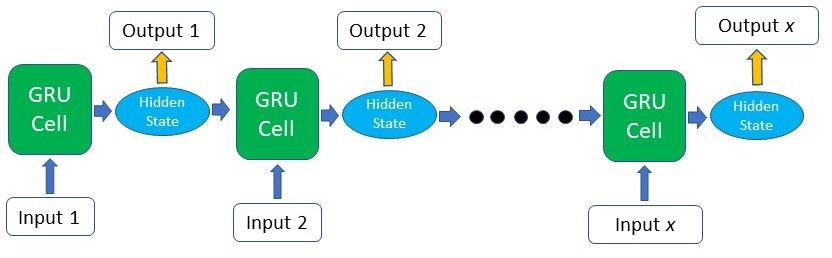

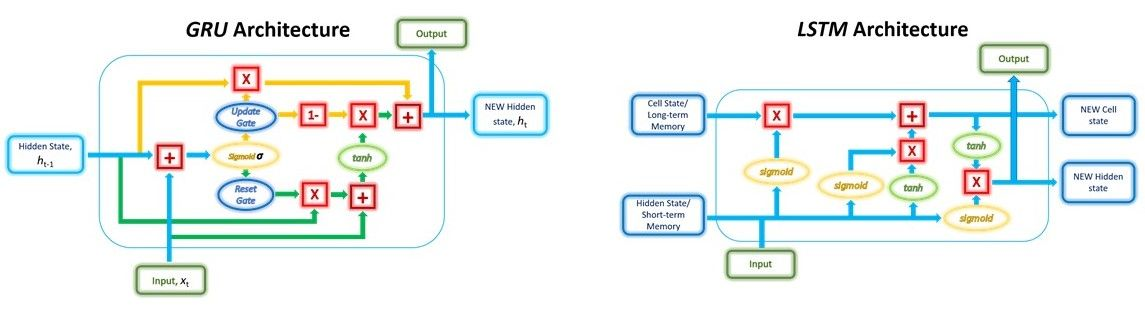

## The ML Pipeline

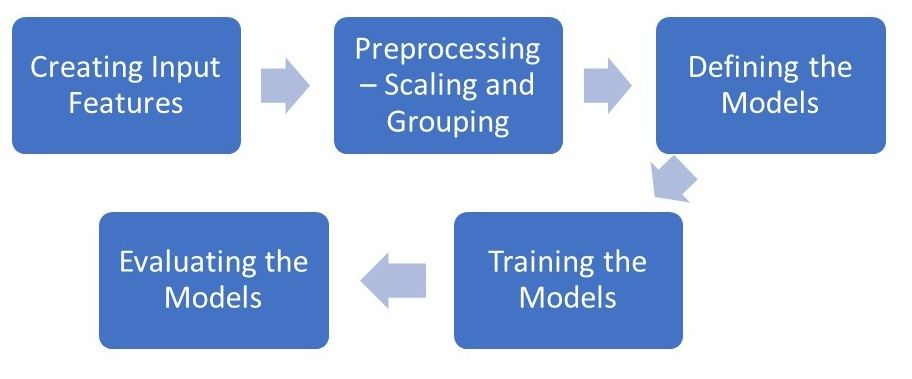

In [15]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [16]:
print(torch.__version__)

1.8.1+cu101


## Exploratory Data Analysis (EDA)

In [18]:
# Define data root directory
data_dir = "./data"
print(os.listdir(data_dir))

['AEP_hourly.csv', 'COMED_hourly.csv', 'DAYTON_hourly.csv', 'DEOK_hourly.csv', 'DOM_hourly.csv', 'DUQ_hourly.csv', 'EKPC_hourly.csv', 'Extra', 'FE_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'PJMW_hourly.csv', 'PJM_Load_hourly.csv']


In [19]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **window_size period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

## Create training instances by moving sliding window

In [20]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

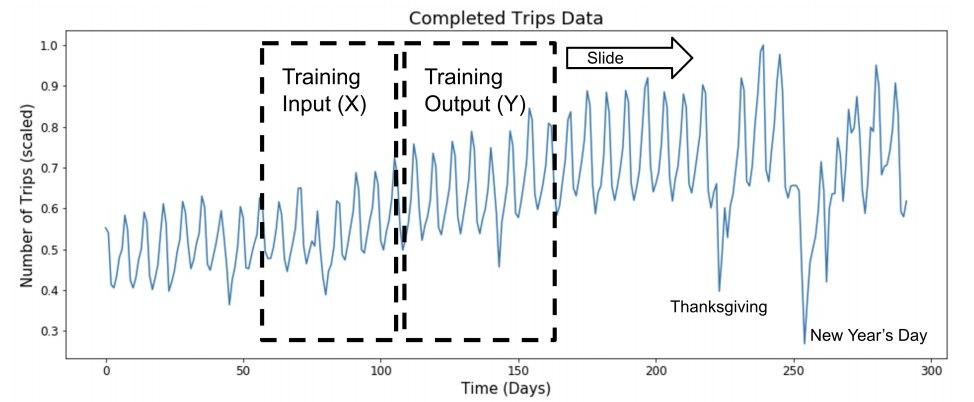

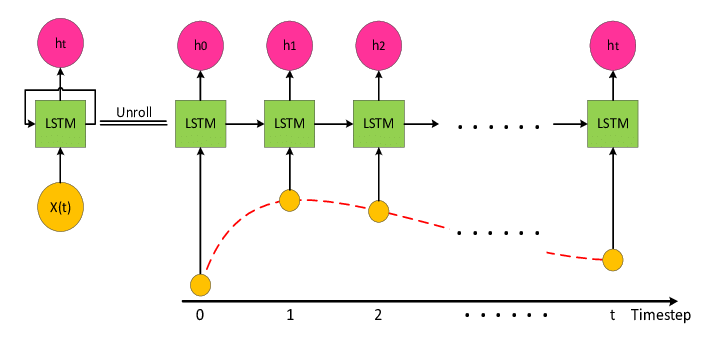

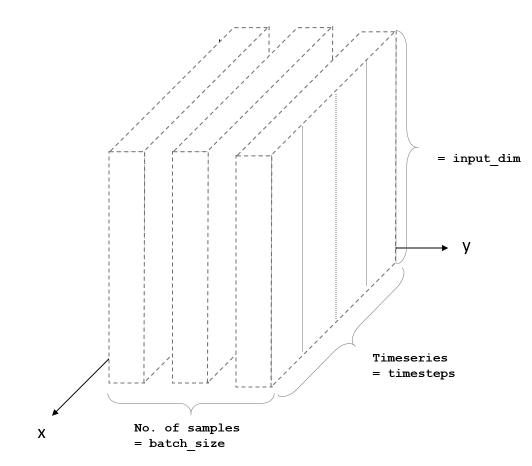

## Integrate files to build the training set
Because the lack of memory and process

In [21]:
label_col_index = 0
inputs_cols_indices = range(5)

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [file if os.path.splitext(file)[1] != ".csv" for file in os.listdir(data_dir)]

for file in tqdm_notebook(processing_files[:5]):

    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/13 [00:00<?, ?it/s]

(121183, 90, 5) (121183, 1)
(66407, 90, 5) (66407, 1)
(121185, 90, 5) (121185, 1)
(57649, 90, 5) (57649, 1)
(116099, 90, 5) (116099, 1)
(118978, 90, 5) (118978, 1)
(45244, 90, 5) (45244, 1)
(62784, 90, 5) (62784, 1)


KeyboardInterrupt: 

## What we made?

In [50]:
train_x.shape, test_x["DEOK_hourly.csv"].shape

((290928, 90, 5), (5764, 90, 5))

## Pytorch data loaders/generators

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The `TensorDataset` and `DataLoader` classes are useful for splitting our data into batches and shuffling them.

In [6]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using "https://colab.research.google.com/" with GPU to run this code, the training time will be significantly reduced.

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


https://pytorch.org/docs/stable/nn.html#torch.nn.GRU

https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM

Next, we'll be defining the structure of the GRU and LSTM models. Both models have the same structure, with the only difference being the **recurrent layer** (GRU/LSTM) and the initializing of the hidden state. The hidden state for the LSTM is a tuple containing both the **cell state** and the **hidden state**, whereas the **GRU only has a single hidden state**.

input_dim = 5 

batch_size = 1024

n_hidden = 256

n_layers = 2

seq_len = 90 (timestamps)

In [8]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):

        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape) select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        # Initialze h_0 with zeros
        # print(hidden.data, hidden)
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )  # c_0
        return hidden

In [9]:
def train(
    train_loader, learn_rate, hidden_dim=256, n_layers=2, EPOCHS=5, model_type="GRU"
):

    # Setting common parameters
    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1, EPOCHS + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % 200 == 0:
                print(
                    f"Epoch {epoch}......Step: {counter}/{len(train_loader)}....... Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(f"Epoch {epoch}/{EPOCHS} Done, Total Loss: {avg_loss/len(train_loader)}")

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

In [10]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (290928, 90, 5), Batch Size: 1024, # of iterations per epoch: 284


## Train a GRU model

In [ ]:
lr = 0.001
gru_model = train(
    train_loader, lr, hidden_dim=256, n_layers=2, EPOCHS=5, model_type="GRU"
)

## Save the GRU model

In [ ]:
torch.save(gru_model.state_dict(), "./models/gru_model.pt")

## Train and Save an LSTM model

In [ ]:
lstm_model = train(
    train_loader, lr, hidden_dim=256, EPOCHS=5, n_layers=2, model_type="LSTM"
)

In [ ]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

As we can see from the training time of both models, the GRU model is the clear winner in terms of speed, as we have mentioned earlier. The GRU finished 5 training epochs 72 seconds faster than the LSTM model.

Moving on to measuring the accuracy of both models, we’ll now use our evaluate() function and test dataset.

## Load the GRU model

In [11]:
hidden_dim = 256
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

<All keys matched successfully>

In [12]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [19]:
hidden_dim = 256
input_dim = next(iter(train_loader))[0].shape[2]
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [20]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation

For the purpose of comparing the performance of both models as well, we'll being tracking the time it takes for the model to train and eventually comparing the final accuracy of both models on the test set. For our accuracy measure, we'll use ***Symmetric Mean Absolute Percentage Error (sMAPE)*** to evaluate the models. *sMAPE* is the sum of the **absolute difference** between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error. 

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$

In [16]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [29]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

## Evaluate performance of GRU

In [17]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 3.6875
sMAPE: 0.656%


## Evaluate performance of LSTM

In [21]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 4.953125
sMAPE: 0.348%


While the LSTM model may have made smaller errors and edged the GRU model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

In [31]:
gru_outputs  # list of predicted output file for each state (each element has a 1d array for that state)

[array([10849.097, 11756.358, 11987.239, ..., 14970.844, 14247.801,
        13637.738], dtype=float32),
 array([3462.6404, 3433.3513, 3343.3062, ..., 3729.701 , 3630.3833,
        3408.1343], dtype=float32),
 array([1779.9606, 1589.132 , 1456.458 , ..., 1679.5765, 1648.5801,
        1537.6825], dtype=float32),
 array([8622.836, 8474.732, 8237.203, ..., 9047.876, 8919.036, 8404.278],
       dtype=float32),
 array([ 9213.801,  9244.328,  9285.598, ..., 11089.52 , 10451.858,
         9965.497], dtype=float32),
 array([32296.885, 35120.688, 37804.367, ..., 33882.035, 31790.168,
        30450.586], dtype=float32)]

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [44]:
states_list = list(test_x.keys())

In [43]:
states_list

['COMED_hourly.csv',
 'DEOK_hourly.csv',
 'EKPC_hourly.csv',
 'FE_hourly.csv',
 'NI_hourly.csv',
 'PJM_Load_hourly.csv']

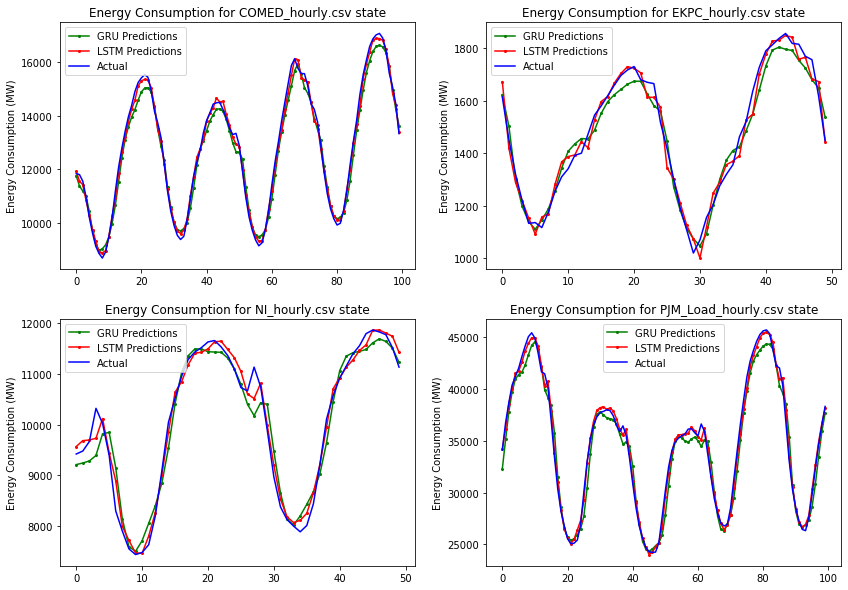

In [48]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(
    lstm_outputs[0][-100:], "-o", color="r", label="LSTM Predictions", markersize=2
)
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(gru_outputs[2][-50:], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[2][-50:], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[2][-50:], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[4][:50], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[4]} state")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gru_outputs[5][:100], "-o", color="g", label="GRU Predictions", markersize=2)
plt.plot(lstm_outputs[5][:100], "-o", color="r", label="LSTM Predictions", markersize=2)
plt.plot(targets[5][:100], color="b", label="Actual")
plt.title(f"Energy Consumption for {states_list[5]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.show()

Looks like the models are largely successful in predicting the trends of energy consumption. While they may still get some changes wrong, such as delays in predicting a drop in consumption, the predictions follow very closely to the actual line on the test set. This is due to the nature of energy consumption data and the fact that there are patterns and cyclical changes that the model can account for. Tougher time-series prediction problems such as stock price prediction or sales volume prediction may have data that is largely random or doesn’t have predictable patterns, and in such cases, the accuracy will definitely be lower.

## What's next?

* Use more data.
* Use more complex (more layers) networks.

## Thank you!

Contact Me: [Amir Masoud Sefidian](http://www.sefidian.com/) amir.masoud.sefidian@gmail.com
            
<img src="./imgs/sefidian-color.png" style="width: 200px;"/>

Inspired from https://blog.floydhub.com/gru-with-pytorch/